In [16]:
"""
MamaCare AI - Maternal Health Risk Assessment
A comprehensive machine learning analysis for predicting maternal health risks
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)
from scipy import stats
import warnings
import joblib
import os
from datetime import datetime

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Create necessary directories
os.makedirs('models', exist_ok=True)
os.makedirs('processed', exist_ok=True)

print("="*80)
print("MAMACARE AI - MATERNAL HEALTH RISK ASSESSMENT")
print("="*80)
print(f"\nAnalysis started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

MAMACARE AI - MATERNAL HEALTH RISK ASSESSMENT

Analysis started: 2025-10-16 22:18:58



In [20]:
# ============================================================================
# DATA LOADING AND EXPLORATION
# ============================================================================
print("\n" + "="*80)
print("DATA LOADING AND EXPLORATION")
print("="*80)

df = pd.read_csv('Dataset - Updated.csv')

print(f"\nDataset shape: {df.shape[0]} samples, {df.shape[1]} features")
print("\nFirst 10 rows:")
print(df.head(10))

print("\n\nDataset information:")
print(df.info())

print("\n\nStatistical summary:")
print(df.describe())


DATA LOADING AND EXPLORATION

Dataset shape: 1205 samples, 12 features

First 10 rows:
   Age  Systolic BP  Diastolic     BS  Body Temp   BMI  \
0   22         90.0       60.0   9.00        100  18.0   
1   22        110.0       70.0   7.10         98  20.4   
2   27        110.0       70.0   7.50         98  23.0   
3   20        100.0       70.0   7.20         98  21.2   
4   20         90.0       60.0   7.50         98  19.7   
5   22        120.0       70.0   7.01         98  24.0   
6   20        110.0       70.0   9.00        102  17.6   
7   23        110.0       80.0   7.00         98  21.3   
8   22         90.0       60.0   6.40         98  22.0   
9   26        110.0       70.0  12.00        100  30.2   

   Previous Complications  Preexisting Diabetes  Gestational Diabetes  \
0                     1.0                   1.0                     0   
1                     0.0                   0.0                     0   
2                     1.0                   0.0       


MISSING DATA ANALYSIS

Missing values detected:
                Column  Missing  Percent
                   BMI       18 1.493776
            Risk Level       18 1.493776
           Systolic BP        5 0.414938
             Diastolic        4 0.331950
                    BS        2 0.165975
Previous Complications        2 0.165975
  Preexisting Diabetes        2 0.165975
            Heart Rate        2 0.165975


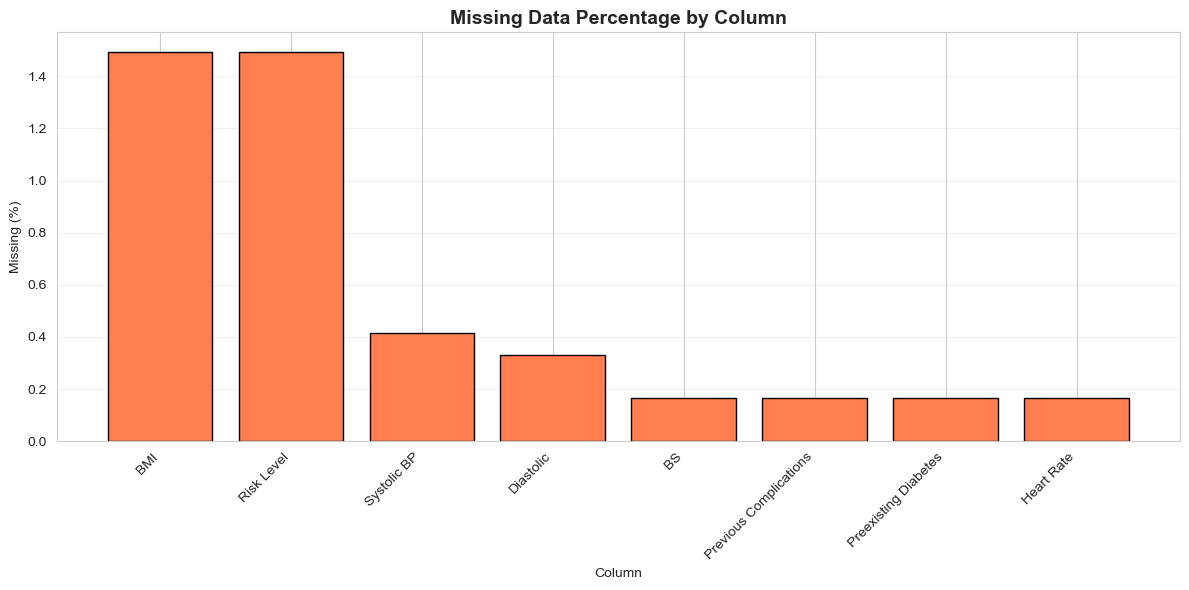


Handling missing values...
  BMI: filled with median (23.00)
  Risk Level: filled with mode (Low)
  Systolic BP: filled with median (120.00)
  Diastolic: filled with median (80.00)
  BS: filled with median (6.90)
  Previous Complications: filled with median (0.00)
  Preexisting Diabetes: filled with median (0.00)
  Heart Rate: filled with median (76.00)


Risk level distribution:
Risk Level
Low     731
High    474
Name: count, dtype: int64

Risk level percentages:
Risk Level
Low     60.66
High    39.34
Name: proportion, dtype: float64


In [21]:
# ============================================================================
# MISSING DATA ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("MISSING DATA ANALYSIS")
print("="*80)

missing_counts = df.isnull().sum()
missing_percent = (missing_counts / len(df)) * 100
missing_data = pd.DataFrame({
    'Column': missing_counts.index,
    'Missing': missing_counts.values,
    'Percent': missing_percent.values
})
missing_data = missing_data[missing_data['Missing'] > 0].sort_values('Missing', ascending=False)

if len(missing_data) > 0:
    print("\nMissing values detected:")
    print(missing_data.to_string(index=False))
    
    # Visualize missing data
    plt.figure(figsize=(12, 6))
    plt.bar(missing_data['Column'], missing_data['Percent'], color='coral', edgecolor='black')
    plt.title('Missing Data Percentage by Column', fontsize=14, fontweight='bold')
    plt.xlabel('Column')
    plt.ylabel('Missing (%)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Handle missing values
    print("\nHandling missing values...")
    for col in missing_data['Column']:
        if df[col].dtype in ['float64', 'int64']:
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)
            print(f"  {col}: filled with median ({median_val:.2f})")
        else:
            mode_val = df[col].mode()[0]
            df[col].fillna(mode_val, inplace=True)
            print(f"  {col}: filled with mode ({mode_val})")
else:
    print("\nNo missing values found")

print("\n\nRisk level distribution:")
print(df['Risk Level'].value_counts())
print("\nRisk level percentages:")
print((df['Risk Level'].value_counts(normalize=True) * 100).round(2))

In [22]:
# ============================================================================
# CLINICAL REFERENCE RANGES
# ============================================================================
print("\n" + "="*80)
print("CLINICAL REFERENCE RANGES")
print("="*80)

clinical_ranges = {
    'Age': {'optimal': (20, 35), 'high_risk': [(15, 19), (35, 100)]},
    'Systolic BP': {'normal': (90, 120), 'elevated': (120, 130), 'hypertension': (130, 180)},
    'Diastolic BP': {'normal': (60, 80), 'elevated': (80, 90), 'hypertension': (90, 120)},
    'BS': {'normal': (3.9, 5.6), 'prediabetes': (5.6, 7.0), 'diabetes': (7.0, 20)},
    'Body Temp': {'normal': (36.5, 37.5), 'fever': (37.5, 100)},
    'BMI': {'underweight': (0, 18.5), 'normal': (18.5, 24.9), 'overweight': (25, 29.9), 'obese': (30, 100)},
    'Heart Rate': {'normal': (60, 100), 'tachycardia': (100, 200)}
}

print("\nClinical thresholds for maternal health:")
for feature, ranges in clinical_ranges.items():
    print(f"\n{feature}:")
    for category, values in ranges.items():
        print(f"  {category}: {values}")


CLINICAL REFERENCE RANGES

Clinical thresholds for maternal health:

Age:
  optimal: (20, 35)
  high_risk: [(15, 19), (35, 100)]

Systolic BP:
  normal: (90, 120)
  elevated: (120, 130)
  hypertension: (130, 180)

Diastolic BP:
  normal: (60, 80)
  elevated: (80, 90)
  hypertension: (90, 120)

BS:
  normal: (3.9, 5.6)
  prediabetes: (5.6, 7.0)
  diabetes: (7.0, 20)

Body Temp:
  normal: (36.5, 37.5)
  fever: (37.5, 100)

BMI:
  underweight: (0, 18.5)
  normal: (18.5, 24.9)
  overweight: (25, 29.9)
  obese: (30, 100)

Heart Rate:
  normal: (60, 100)
  tachycardia: (100, 200)


In [25]:
# Clean all column names once
df.columns = (
    df.columns
      .str.encode('ascii', 'ignore').str.decode('utf-8')  # remove non-ascii chars
      .str.strip()  # remove spaces front/back
      .str.replace('\ufeff', '', regex=True)  # remove BOM
      .str.replace('\xa0', ' ', regex=True)  # replace non-breaking spaces
)

# Verify the cleaned names
print(df.columns.tolist())

['age', 'systolic_bp', 'diastolic', 'bs', 'body_temp', 'bmi', 'previous_complications', 'preexisting_diabetes', 'gestational_diabetes', 'mental_health', 'heart_rate', 'risk_level']



EXPLORATORY DATA ANALYSIS

Generating distribution plots...


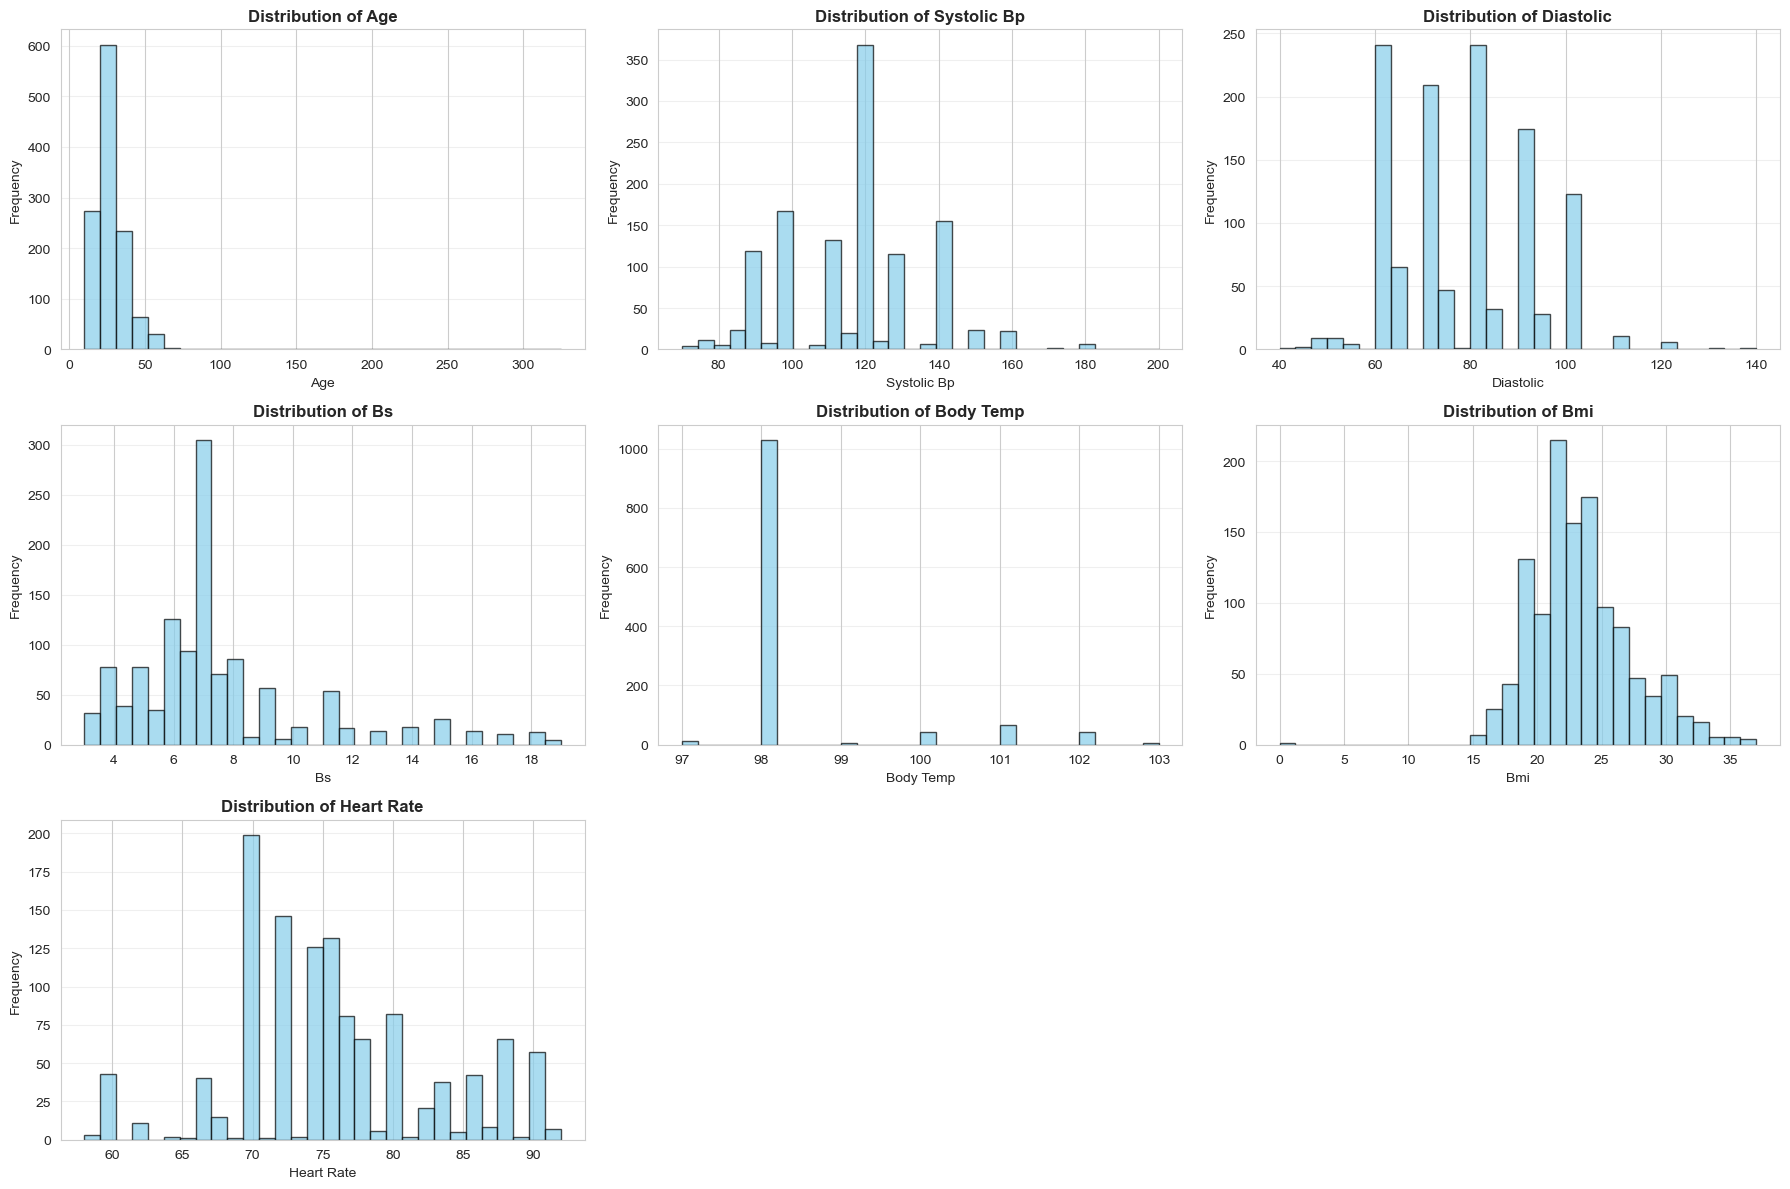


Generating box plots for outlier detection...


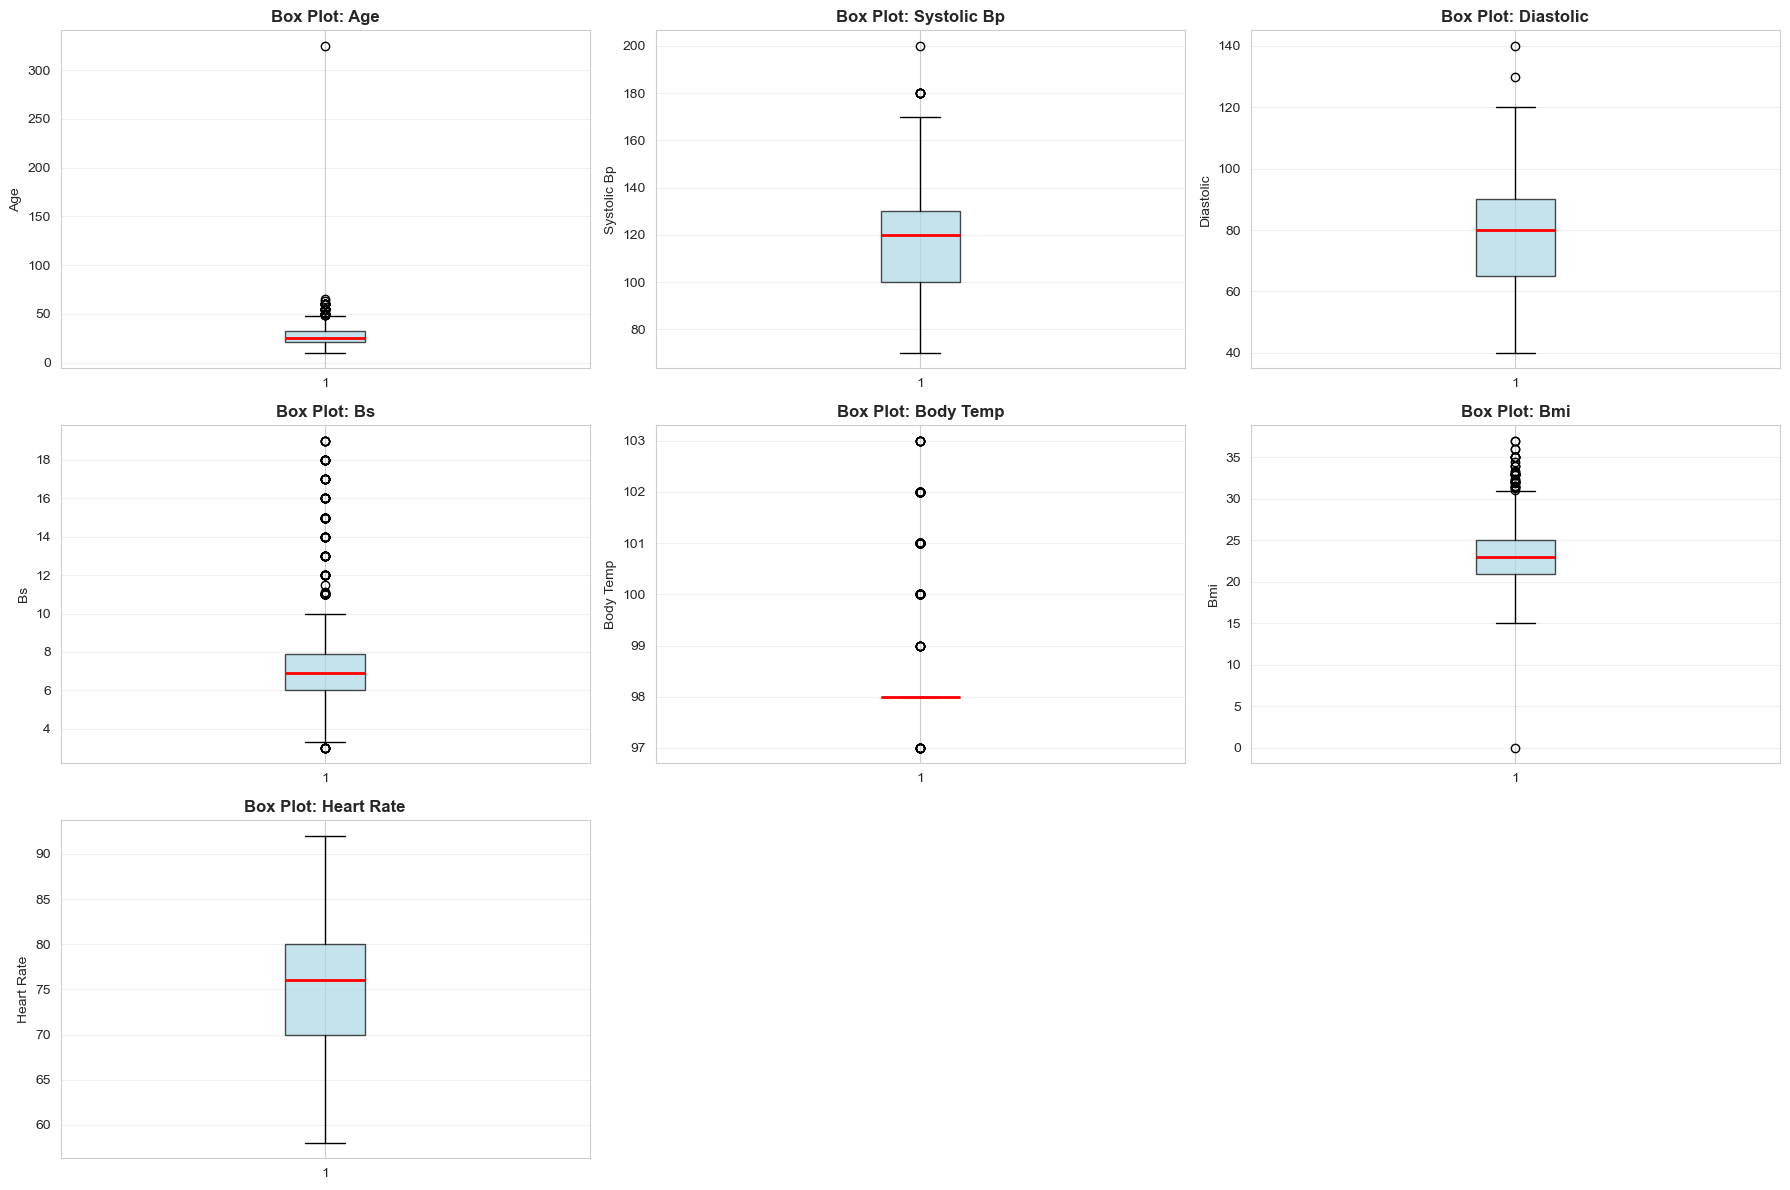


Generating distributions by risk level...


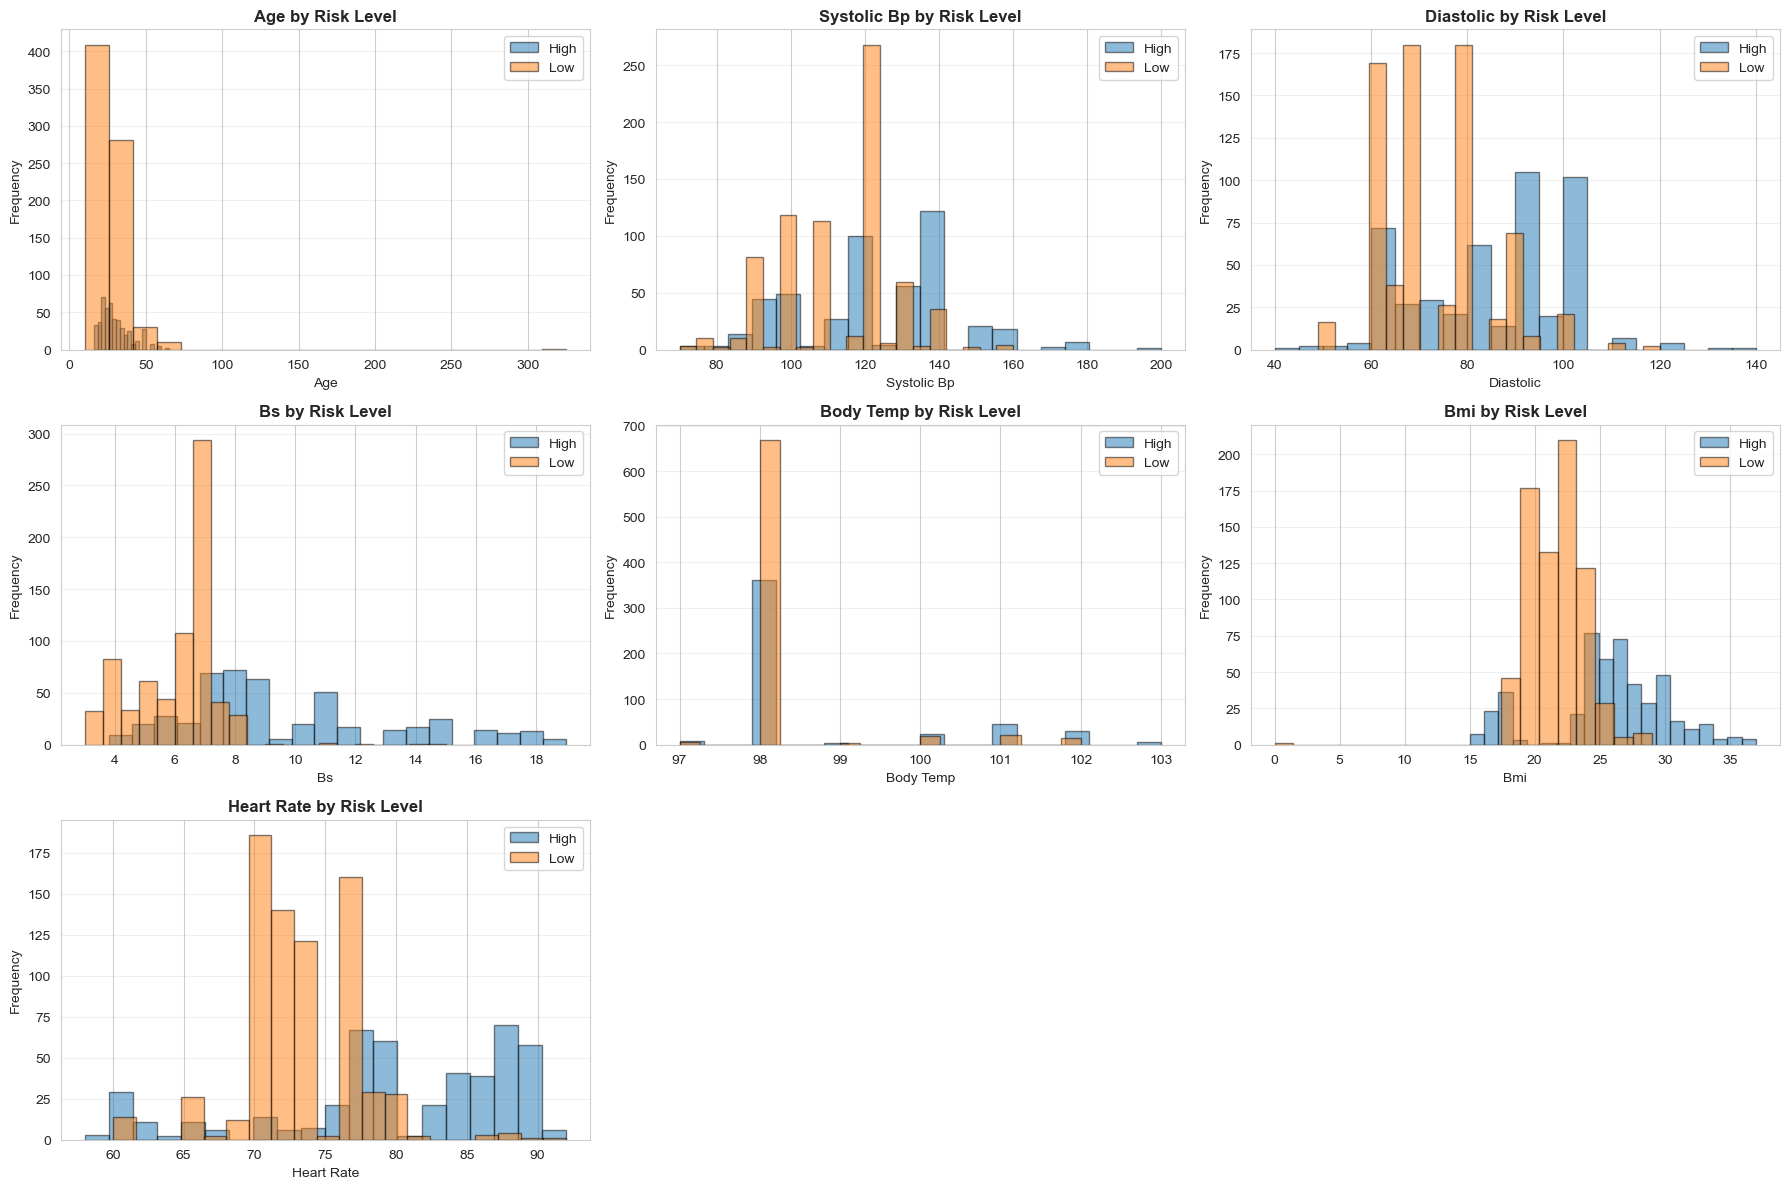


Generating violin plots...


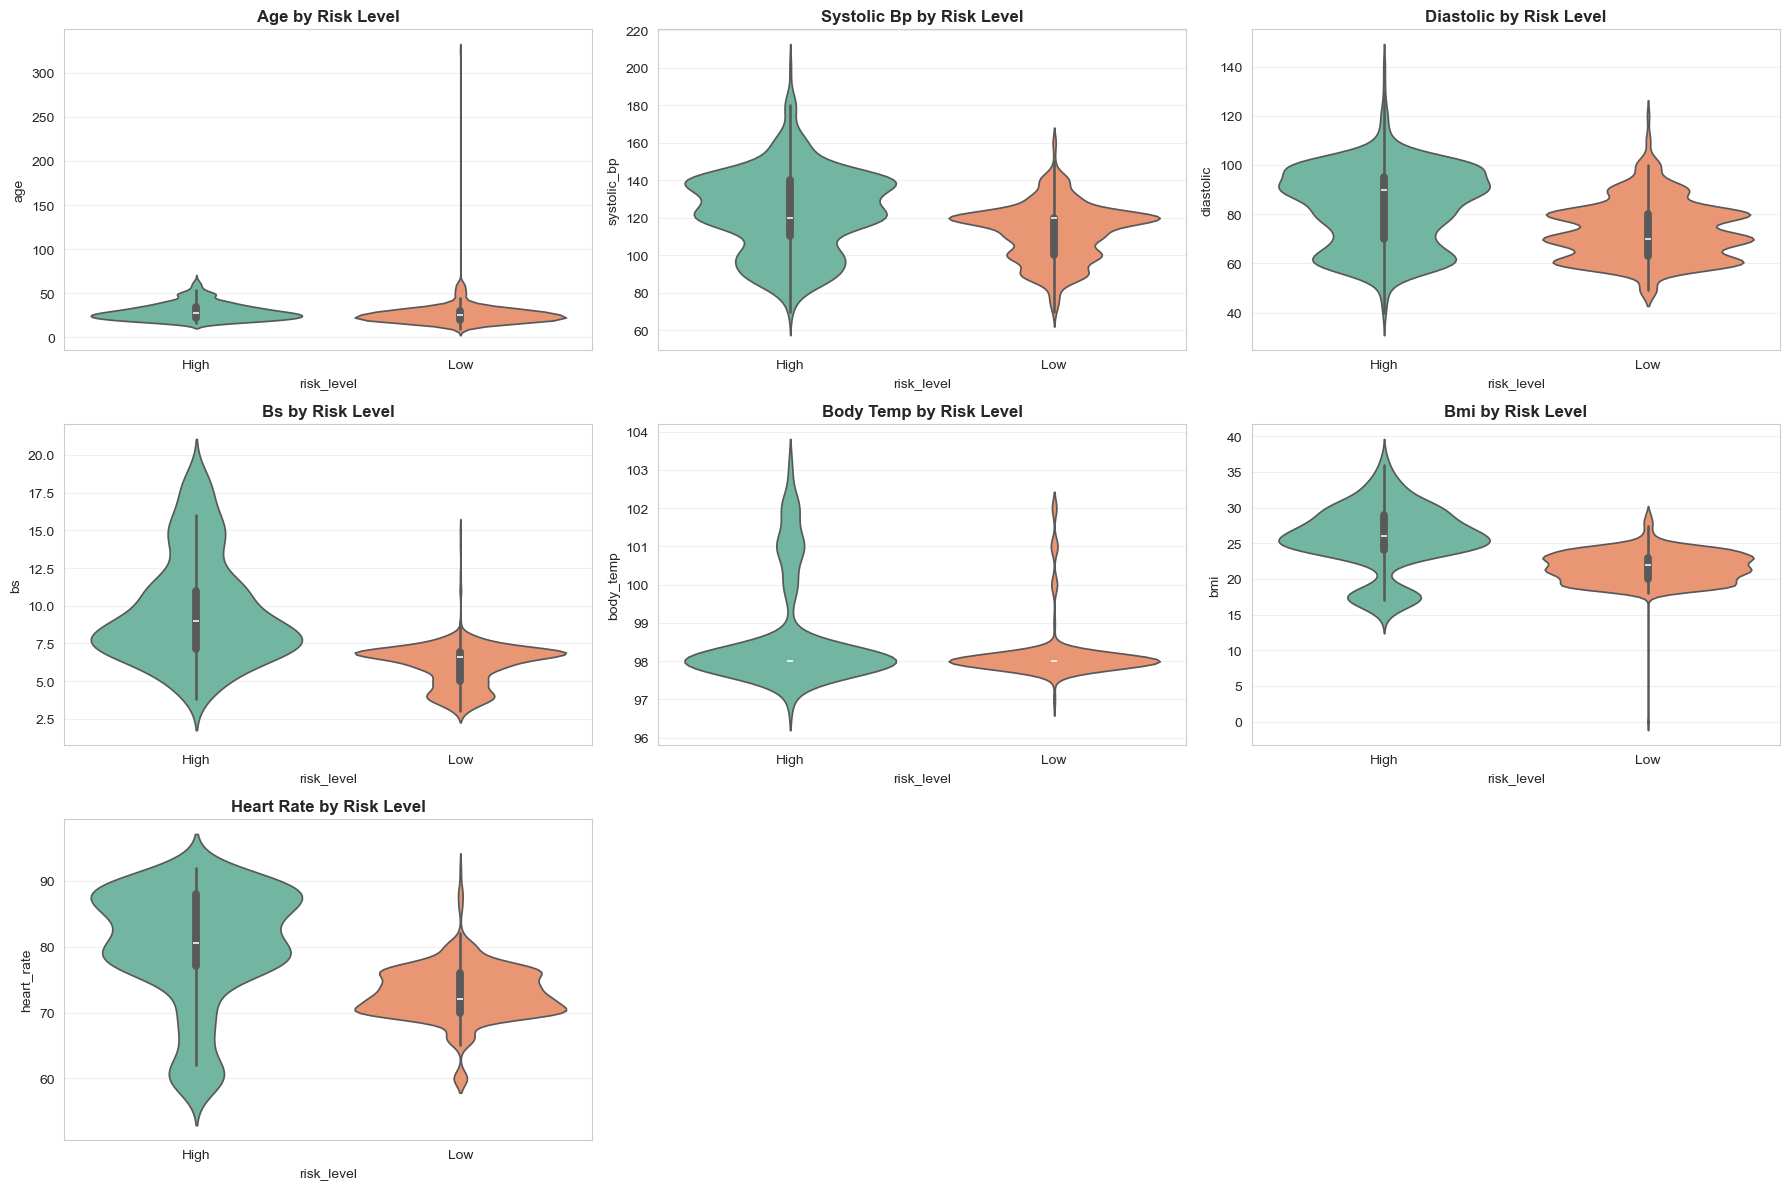

In [27]:
# ============================================================================
# EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

print("\n" + "="*80)
print("EXPLORATORY DATA ANALYSIS")
print("="*80)

# --- Clean column names ---
df.columns = (
    df.columns.str.strip()  # Remove extra spaces
             .str.lower()    # Lowercase
             .str.replace(' ', '_')  # Replace spaces with underscores
             .str.replace('-', '_')  # Replace hyphens with underscores
)

# Now define numerical features based on cleaned names
numerical_features = ['age', 'systolic_bp', 'diastolic', 'bs', 'body_temp', 'bmi', 'heart_rate']

# --- Distribution plots ---
print("\nGenerating distribution plots...")
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, feature in enumerate(numerical_features):
    if feature in df.columns:
        axes[idx].hist(df[feature], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'Distribution of {feature.replace("_", " ").title()}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(feature.replace("_", " ").title())
        axes[idx].set_ylabel('Frequency')
        axes[idx].grid(axis='y', alpha=0.3)
    else:
        axes[idx].text(0.5, 0.5, f"'{feature}' not found", ha='center', va='center', color='red')
        axes[idx].set_title(feature)

for idx in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# --- Box plots for outlier detection ---
print("\nGenerating box plots for outlier detection...")
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, feature in enumerate(numerical_features):
    if feature in df.columns:
        axes[idx].boxplot(df[feature], vert=True, patch_artist=True,
                          boxprops=dict(facecolor='lightblue', alpha=0.7),
                          medianprops=dict(color='red', linewidth=2))
        axes[idx].set_title(f'Box Plot: {feature.replace("_", " ").title()}', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel(feature.replace("_", " ").title())
        axes[idx].grid(axis='y', alpha=0.3)
    else:
        axes[idx].text(0.5, 0.5, f"'{feature}' not found", ha='center', va='center', color='red')

for idx in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# --- Distributions by Risk Level ---
print("\nGenerating distributions by risk level...")
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.ravel()

risk_col = 'risk_level' if 'risk_level' in df.columns else 'Risk Level'
for idx, feature in enumerate(numerical_features):
    if feature in df.columns:
        for risk_level in df[risk_col].unique():
            data = df[df[risk_col] == risk_level][feature]
            axes[idx].hist(data, bins=20, alpha=0.5, label=risk_level, edgecolor='black')
        
        axes[idx].set_title(f'{feature.replace("_", " ").title()} by Risk Level', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(feature.replace("_", " ").title())
        axes[idx].set_ylabel('Frequency')
        axes[idx].legend()
        axes[idx].grid(axis='y', alpha=0.3)
    else:
        axes[idx].text(0.5, 0.5, f"'{feature}' not found", ha='center', va='center', color='red')

for idx in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# --- Violin plots ---
print("\nGenerating violin plots...")
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, feature in enumerate(numerical_features):
    if feature in df.columns:
        sns.violinplot(data=df, x=risk_col, y=feature, ax=axes[idx], palette='Set2')
        axes[idx].set_title(f'{feature.replace("_", " ").title()} by Risk Level', fontsize=12, fontweight='bold')
        axes[idx].grid(axis='y', alpha=0.3)
    else:
        axes[idx].text(0.5, 0.5, f"'{feature}' not found", ha='center', va='center', color='red')

for idx in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


CORRELATION ANALYSIS

Using features for correlation: ['age', 'systolic_bp', 'diastolic', 'bs', 'body_temp', 'bmi', 'heart_rate', 'previous_complications', 'preexisting_diabetes', 'gestational_diabetes', 'mental_health', 'Risk_Encoded']

Correlation with Risk Level:
Risk_Encoded              1.000000
age                      -0.128037
body_temp                -0.211383
systolic_bp              -0.287671
diastolic                -0.330050
gestational_diabetes     -0.443348
heart_rate               -0.481183
bmi                      -0.518454
previous_complications   -0.540870
bs                       -0.589095
mental_health            -0.631853
preexisting_diabetes     -0.680952
Name: Risk_Encoded, dtype: float64

Generating correlation heatmap...


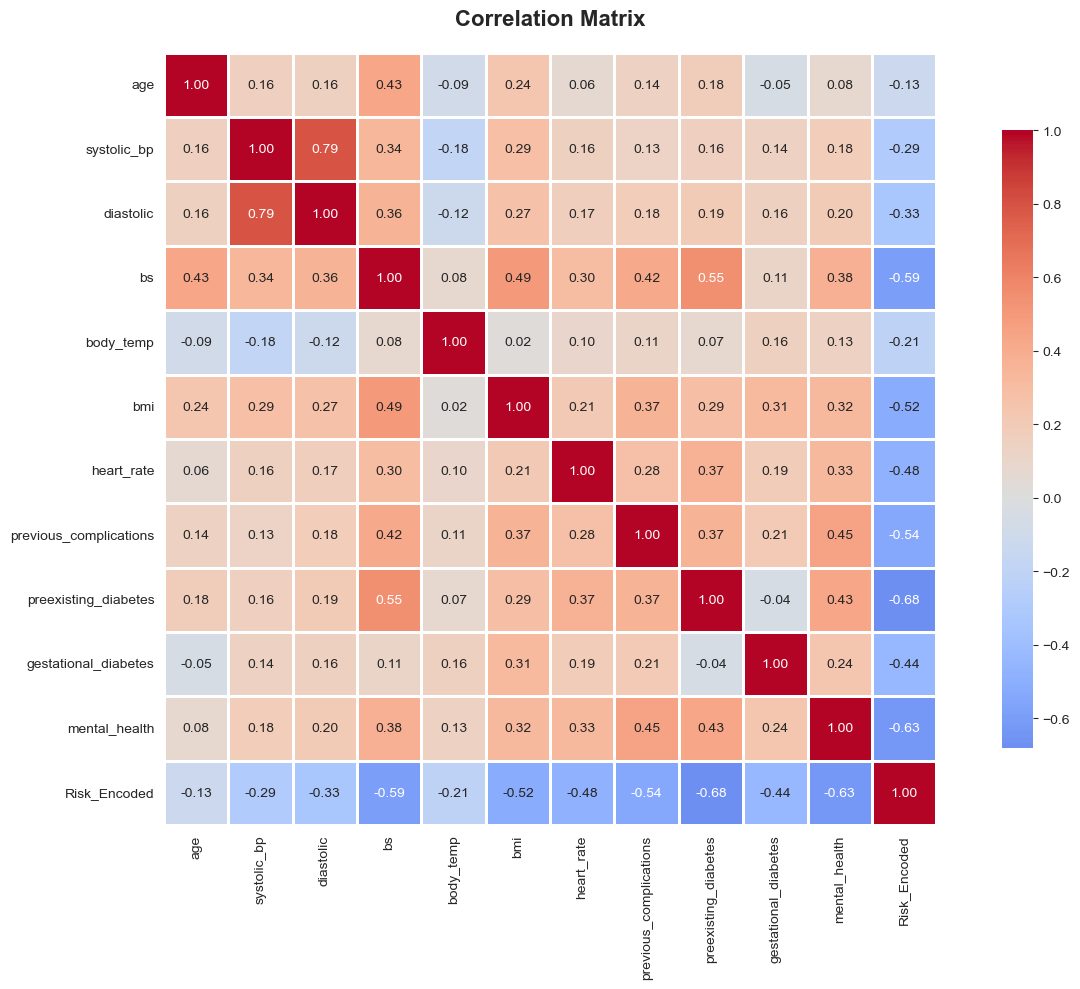

In [37]:
# ============================================================================
# CORRELATION ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("CORRELATION ANALYSIS")
print("="*80)

from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# Encode the risk level safely
if 'Risk Level' in df.columns:
    df['Risk_Encoded'] = LabelEncoder().fit_transform(df['Risk Level'])
elif 'risk_level' in df.columns:
    df['Risk_Encoded'] = LabelEncoder().fit_transform(df['risk_level'])
else:
    raise KeyError("No 'Risk Level' or 'risk_level' column found in dataset.")

# Try to include all intended columns, but only keep the ones that exist
candidate_features = numerical_features + [
    'previous_complications', 'preexisting_diabetes', 'gestational_diabetes', 'mental_health', 'Risk_Encoded', 
]

# Keep only available columns
corr_features = [f for f in candidate_features if f in df.columns]
print(f"\nUsing features for correlation: {corr_features}")

# Compute correlation matrix
correlation_matrix = df[corr_features].corr()

# Display correlation with risk level
if 'Risk_Encoded' in correlation_matrix.columns:
    print("\nCorrelation with Risk Level:")
    print(correlation_matrix['Risk_Encoded'].sort_values(ascending=False))
else:
    print("\n⚠️ 'Risk_Encoded' not found in correlation matrix.")

# Plot correlation heatmap
print("\nGenerating correlation heatmap...")
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


BINARY FEATURES ANALYSIS

Generating binary features analysis...


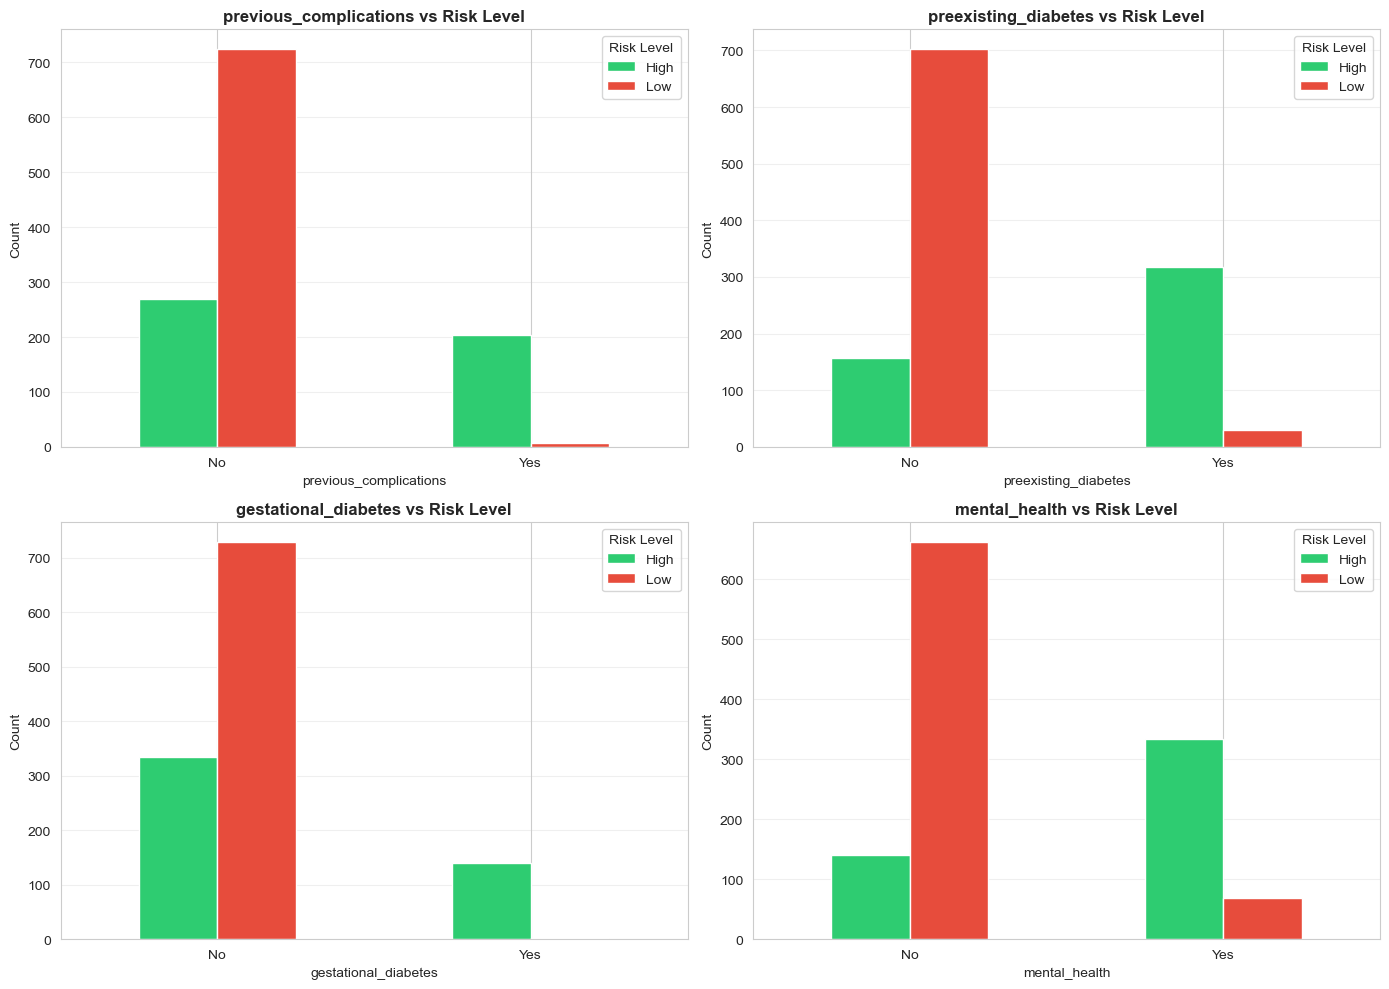

In [36]:
# ============================================================================
# BINARY FEATURES ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("BINARY FEATURES ANALYSIS")
print("="*80)

binary_features = ['previous_complications', 'preexisting_diabetes', 'gestational_diabetes', 'mental_health']

print("\nGenerating binary features analysis...")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, feature in enumerate(binary_features):
    risk_counts = df.groupby([feature, 'risk_level']).size().unstack(fill_value=0)
    risk_counts.plot(kind='bar', ax=axes[idx], color=['#2ecc71', '#e74c3c', '#f39c12'])
    axes[idx].set_title(f'{feature} vs Risk Level', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Count')
    axes[idx].legend(title='Risk Level')
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].set_xticklabels(['No', 'Yes'], rotation=0)

plt.tight_layout()
plt.show()

In [40]:
# ============================================================================
# STATISTICAL SIGNIFICANCE TESTS
# ============================================================================
print("\n" + "="*80)
print("STATISTICAL SIGNIFICANCE TESTS")
print("="*80)

high_risk = df[df['risk_level'] == 'High']
low_risk = df[df['risk_level'] == 'Low']

print("\nT-tests (High Risk vs Low Risk):")
for feature in numerical_features:
    t_stat, p_value = stats.ttest_ind(high_risk[feature].dropna(), low_risk[feature].dropna())
    sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    print(f"  {feature:20s}: t={t_stat:8.3f}, p={p_value:.6f} {sig}")

print("\nChi-square tests (Binary features vs Risk Level):")
for feature in binary_features:
    contingency = pd.crosstab(df[feature], df['risk_level'])
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency)
    sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    print(f"  {feature:30s}: chi2={chi2:8.3f}, p={p_value:.6f} {sig}")

print("\nSignificance: *** p<0.001, ** p<0.01, * p<0.05, ns=not significant")


STATISTICAL SIGNIFICANCE TESTS

T-tests (High Risk vs Low Risk):
  age                 : t=   4.478, p=0.000008 ***
  systolic_bp         : t=  10.418, p=0.000000 ***
  diastolic           : t=  12.127, p=0.000000 ***
  bs                  : t=  25.286, p=0.000000 ***
  body_temp           : t=   7.501, p=0.000000 ***
  bmi                 : t=  21.029, p=0.000000 ***
  heart_rate          : t=  19.038, p=0.000000 ***

Chi-square tests (Binary features vs Risk Level):
  previous_complications        : chi2= 349.604, p=0.000000 ***
  preexisting_diabetes          : chi2= 555.679, p=0.000000 ***
  gestational_diabetes          : chi2= 234.046, p=0.000000 ***
  mental_health                 : chi2= 478.344, p=0.000000 ***

Significance: *** p<0.001, ** p<0.01, * p<0.05, ns=not significant



FEATURE ENGINEERING

Creating medically-informed features...
  Mean Arterial Pressure (MAP)
  Pulse Pressure
  Hypertension indicator
  Diabetes indicator
  Fever indicator
  Tachycardia indicator
  Risk factor count
  Age risk indicator
  BMI risk indicator

Total features: 22

Visualizing engineered features...


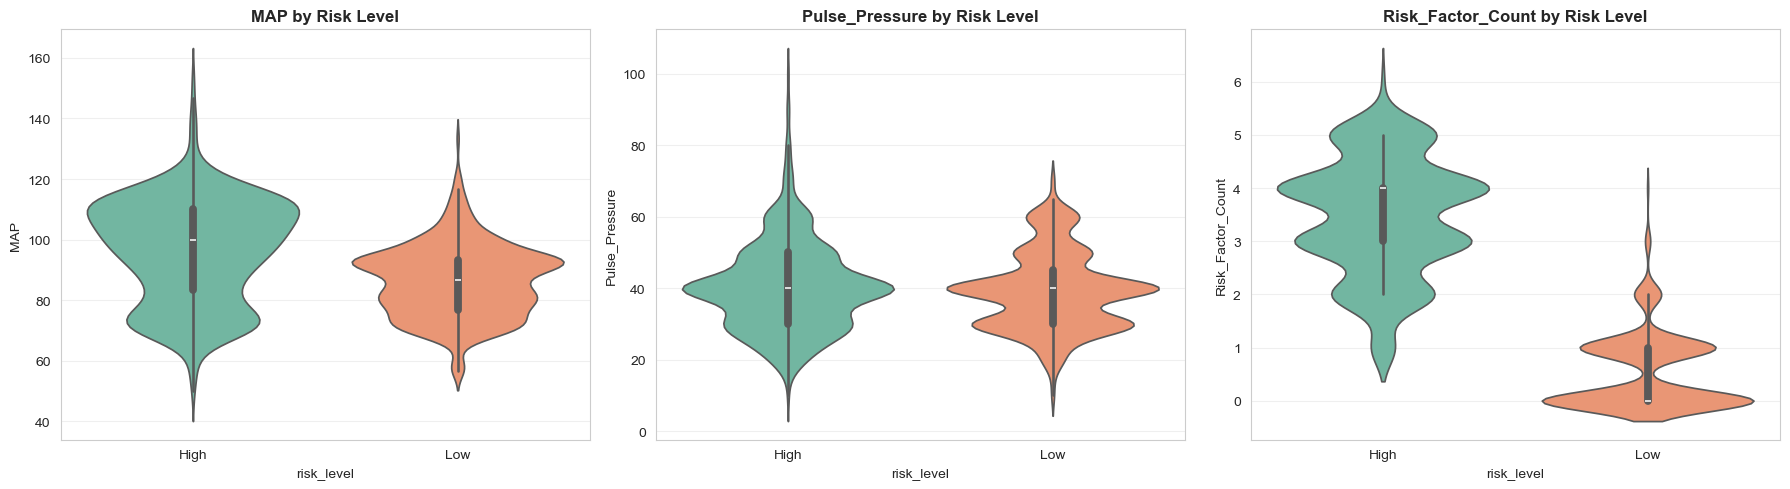

In [44]:
# ============================================================================
# FEATURE ENGINEERING
# ============================================================================
print("\n" + "="*80)
print("FEATURE ENGINEERING")
print("="*80)

print("\nCreating medically-informed features...")

df['MAP'] = (df['systolic_bp'] + 2 * df['diastolic']) / 3
df['Pulse_Pressure'] = df['systolic_bp'] - df['diastolic']
df['Has_Hypertension'] = ((df['systolic_bp'] >= 140) | (df['diastolic'] >= 90)).astype(int)
df['Has_Diabetes'] = (df['bs'] >= 7.0).astype(int)
df['Has_Fever'] = (df['body_temp'] > 37.5).astype(int)
df['Has_Tachycardia'] = (df['heart_rate'] > 100).astype(int)
df['Risk_Factor_Count'] = (
    df['previous_complications'] + df['preexisting_diabetes'] + 
    df['gestational_diabetes'] + df['mental_health'] +
    df['Has_Hypertension'] + df['Has_Diabetes'] + df['Has_Tachycardia']
)
df['Age_Risk'] = ((df['age'] < 20) | (df['age'] > 35)).astype(int)
df['BMI_Risk'] = ((df['bmi'] < 18.5) | (df['bmi'] >= 30)).astype(int)

print("  Mean Arterial Pressure (MAP)")
print("  Pulse Pressure")
print("  Hypertension indicator")
print("  Diabetes indicator")
print("  Fever indicator")
print("  Tachycardia indicator")
print("  Risk factor count")
print("  Age risk indicator")
print("  BMI risk indicator")

print(f"\nTotal features: {df.shape[1]}")

print("\nVisualizing engineered features...")
engineered_features = ['MAP', 'Pulse_Pressure', 'Risk_Factor_Count']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, feature in enumerate(engineered_features):
    sns.violinplot(data=df, x='risk_level', y=feature, ax=axes[idx], palette='Set2')
    axes[idx].set_title(f'{feature} by Risk Level', fontsize=12, fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [49]:
# ============================================================================
# DATA PREPARATION
# ============================================================================
print("\n" + "="*80)
print("DATA PREPARATION")
print("="*80)

# Define features (excluding target column 'risk_level')
feature_columns = [
    'age', 'systolic_bp', 'diastolic', 'bs', 'body_temp', 'bmi',
    'previous_complications', 'preexisting_diabetes', 'gestational_diabetes',
    'mental_health', 'heart_rate',
    'MAP', 'Pulse_Pressure', 'Has_Hypertension', 'Has_Diabetes', 'Has_Fever',
    'Has_Tachycardia', 'Risk_Factor_Count', 'Age_Risk', 'BMI_Risk'
]

# Features (X) and target (y)
X = df[feature_columns]
y = df['risk_level']

print(f"\nFeature matrix: {X.shape}")
print(f"Target variable: {y.shape}")
print(f"\nFeatures ({len(feature_columns)}):")
for i, feat in enumerate(feature_columns, 1):
    print(f"  {i:2d}. {feat}")

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"\nTarget encoding:")
for i, label in enumerate(label_encoder.classes_):
    print(f"  {label} -> {i}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Standardize numerical features only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled using StandardScaler")

# Optional: convert back to DataFrame (for readability)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_columns)


DATA PREPARATION

Feature matrix: (1205, 20)
Target variable: (1205,)

Features (20):
   1. age
   2. systolic_bp
   3. diastolic
   4. bs
   5. body_temp
   6. bmi
   7. previous_complications
   8. preexisting_diabetes
   9. gestational_diabetes
  10. mental_health
  11. heart_rate
  12. MAP
  13. Pulse_Pressure
  14. Has_Hypertension
  15. Has_Diabetes
  16. Has_Fever
  17. Has_Tachycardia
  18. Risk_Factor_Count
  19. Age_Risk
  20. BMI_Risk

Target encoding:
  High -> 0
  Low -> 1

Train set: 964 samples
Test set: 241 samples

Features scaled using StandardScaler


In [50]:
# ============================================================================
# MODEL TRAINING
# ============================================================================
print("\n" + "="*80)
print("MODEL TRAINING")
print("="*80)

models = {}
results = {}

# Logistic Regression
print("\n" + "-"*80)
print("LOGISTIC REGRESSION")
print("-"*80)

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)

models['Logistic Regression'] = lr_model

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=label_encoder.classes_))

results['Logistic Regression'] = {
    'accuracy': accuracy_score(y_test, y_pred_lr),
    'precision': precision_score(y_test, y_pred_lr, average='weighted'),
    'recall': recall_score(y_test, y_pred_lr, average='weighted'),
    'f1': f1_score(y_test, y_pred_lr, average='weighted'),
    'predictions': y_pred_lr,
    'probabilities': y_pred_proba_lr
}

# Random Forest
print("\n" + "-"*80)
print("RANDOM FOREST")
print("-"*80)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)

models['Random Forest'] = rf_model

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))

results['Random Forest'] = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'precision': precision_score(y_test, y_pred_rf, average='weighted'),
    'recall': recall_score(y_test, y_pred_rf, average='weighted'),
    'f1': f1_score(y_test, y_pred_rf, average='weighted'),
    'predictions': y_pred_rf,
    'probabilities': y_pred_proba_rf
}

feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 important features:")
print(feature_importance.head(10).to_string(index=False))

# Gradient Boosting
print("\n" + "-"*80)
print("GRADIENT BOOSTING")
print("-"*80)

gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)
y_pred_gb = gb_model.predict(X_test_scaled)
y_pred_proba_gb = gb_model.predict_proba(X_test_scaled)

models['Gradient Boosting'] = gb_model

print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb, target_names=label_encoder.classes_))

results['Gradient Boosting'] = {
    'accuracy': accuracy_score(y_test, y_pred_gb),
    'precision': precision_score(y_test, y_pred_gb, average='weighted'),
    'recall': recall_score(y_test, y_pred_gb, average='weighted'),
    'f1': f1_score(y_test, y_pred_gb, average='weighted'),
    'predictions': y_pred_gb,
    'probabilities': y_pred_proba_gb
}

# Support Vector Machine
print("\n" + "-"*80)
print("SUPPORT VECTOR MACHINE")
print("-"*80)

svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)
y_pred_proba_svm = svm_model.predict_proba(X_test_scaled)

models['SVM'] = svm_model

print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_))

results['SVM'] = {
    'accuracy': accuracy_score(y_test, y_pred_svm),
    'precision': precision_score(y_test, y_pred_svm, average='weighted'),
    'recall': recall_score(y_test, y_pred_svm, average='weighted'),
    'f1': f1_score(y_test, y_pred_svm, average='weighted'),
    'predictions': y_pred_svm,
    'probabilities': y_pred_proba_svm
}


MODEL TRAINING

--------------------------------------------------------------------------------
LOGISTIC REGRESSION
--------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

        High       0.96      0.96      0.96        95
         Low       0.97      0.97      0.97       146

    accuracy                           0.97       241
   macro avg       0.97      0.97      0.97       241
weighted avg       0.97      0.97      0.97       241


--------------------------------------------------------------------------------
RANDOM FOREST
--------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

        High       0.97      0.99      0.98        95
         Low       0.99      0.98      0.99       146

    accuracy                           0.98       241
   macro avg       0.98      0.


MODEL COMPARISON

Model performance comparison:
              Model  Accuracy  Precision   Recall  F1-Score
Logistic Regression  0.966805   0.966805 0.966805  0.966805
      Random Forest  0.983402   0.983602 0.983402  0.983432
  Gradient Boosting  0.987552   0.987564 0.987552  0.987540
                SVM  0.975104   0.975825 0.975104  0.975188

Best model: Gradient Boosting (F1=0.9875)

Generating comparison plots...


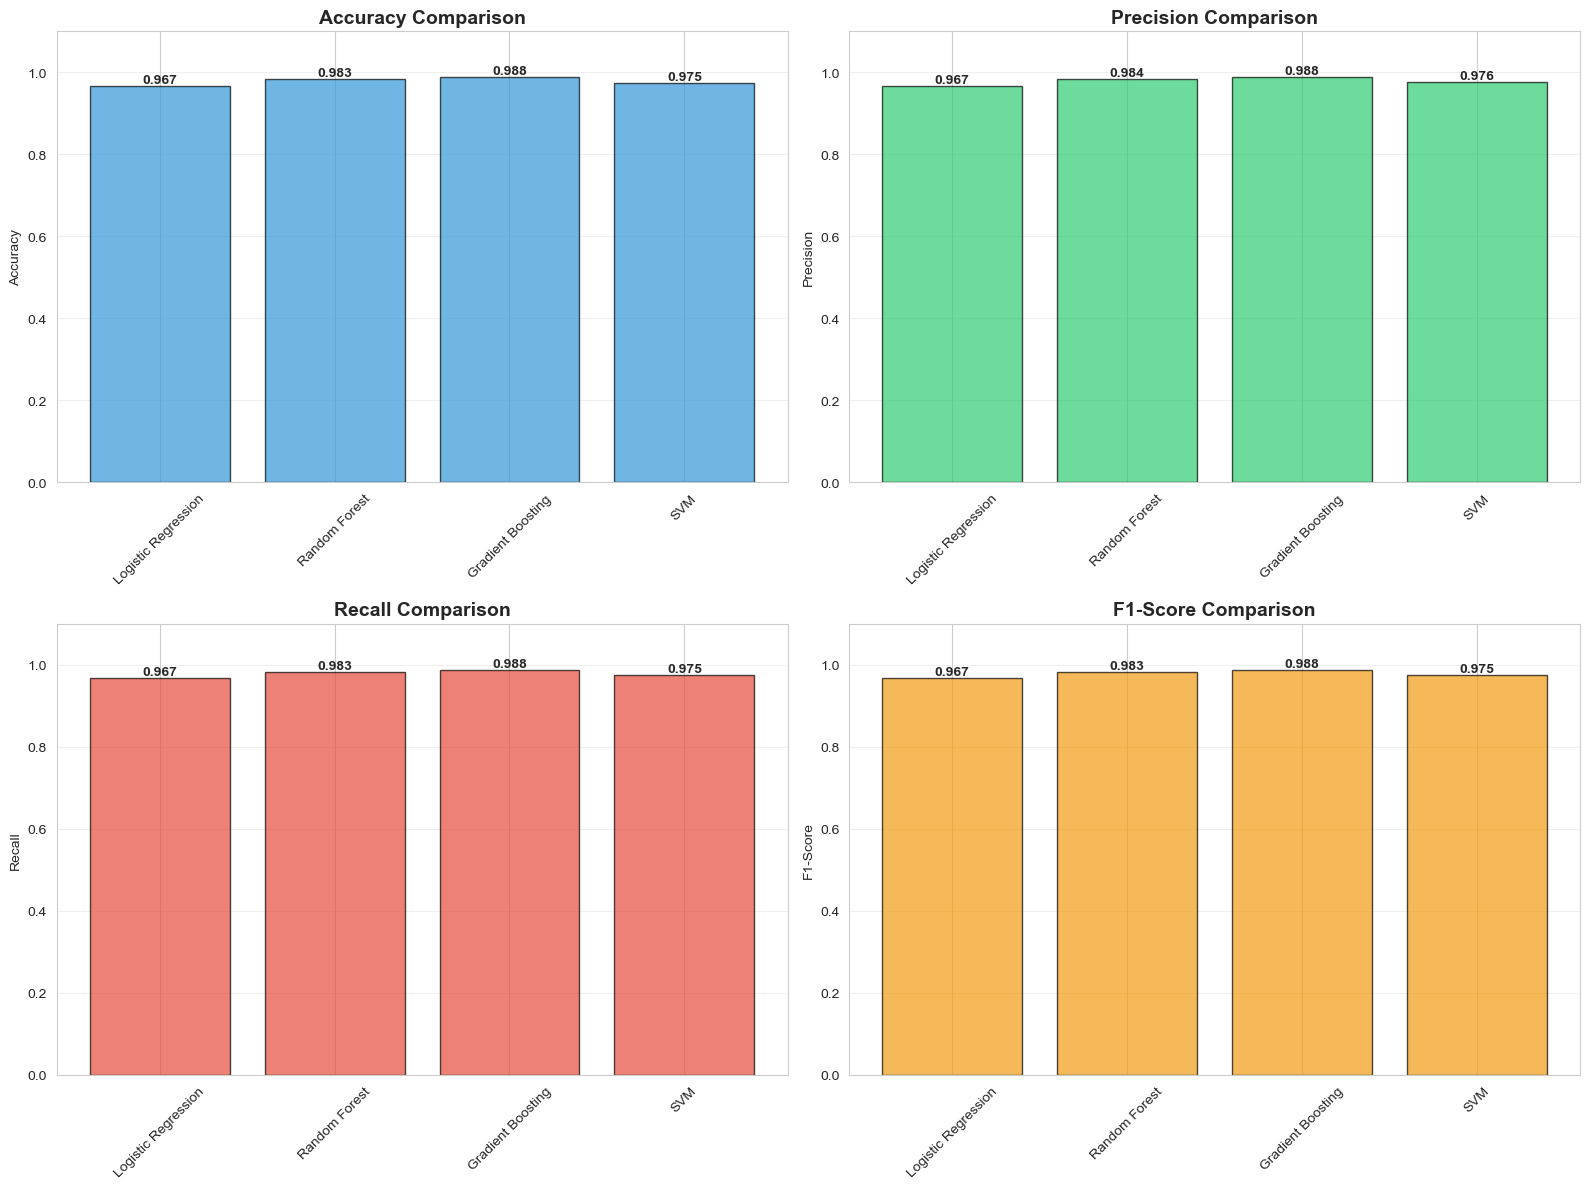

In [51]:
# ============================================================================
# MODEL COMPARISON
# ============================================================================
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1-Score': [results[m]['f1'] for m in results.keys()]
})

print("\nModel performance comparison:")
print(comparison_df.to_string(index=False))

best_model_name = comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Model']
print(f"\nBest model: {best_model_name} (F1={comparison_df['F1-Score'].max():.4f})")

print("\nGenerating comparison plots...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    bars = ax.bar(comparison_df['Model'], comparison_df[metric], color=colors[idx], alpha=0.7, edgecolor='black')
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_ylabel(metric)
    ax.set_ylim([0, 1.1])
    ax.grid(axis='y', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
    
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


CONFUSION MATRICES

Generating confusion matrices...


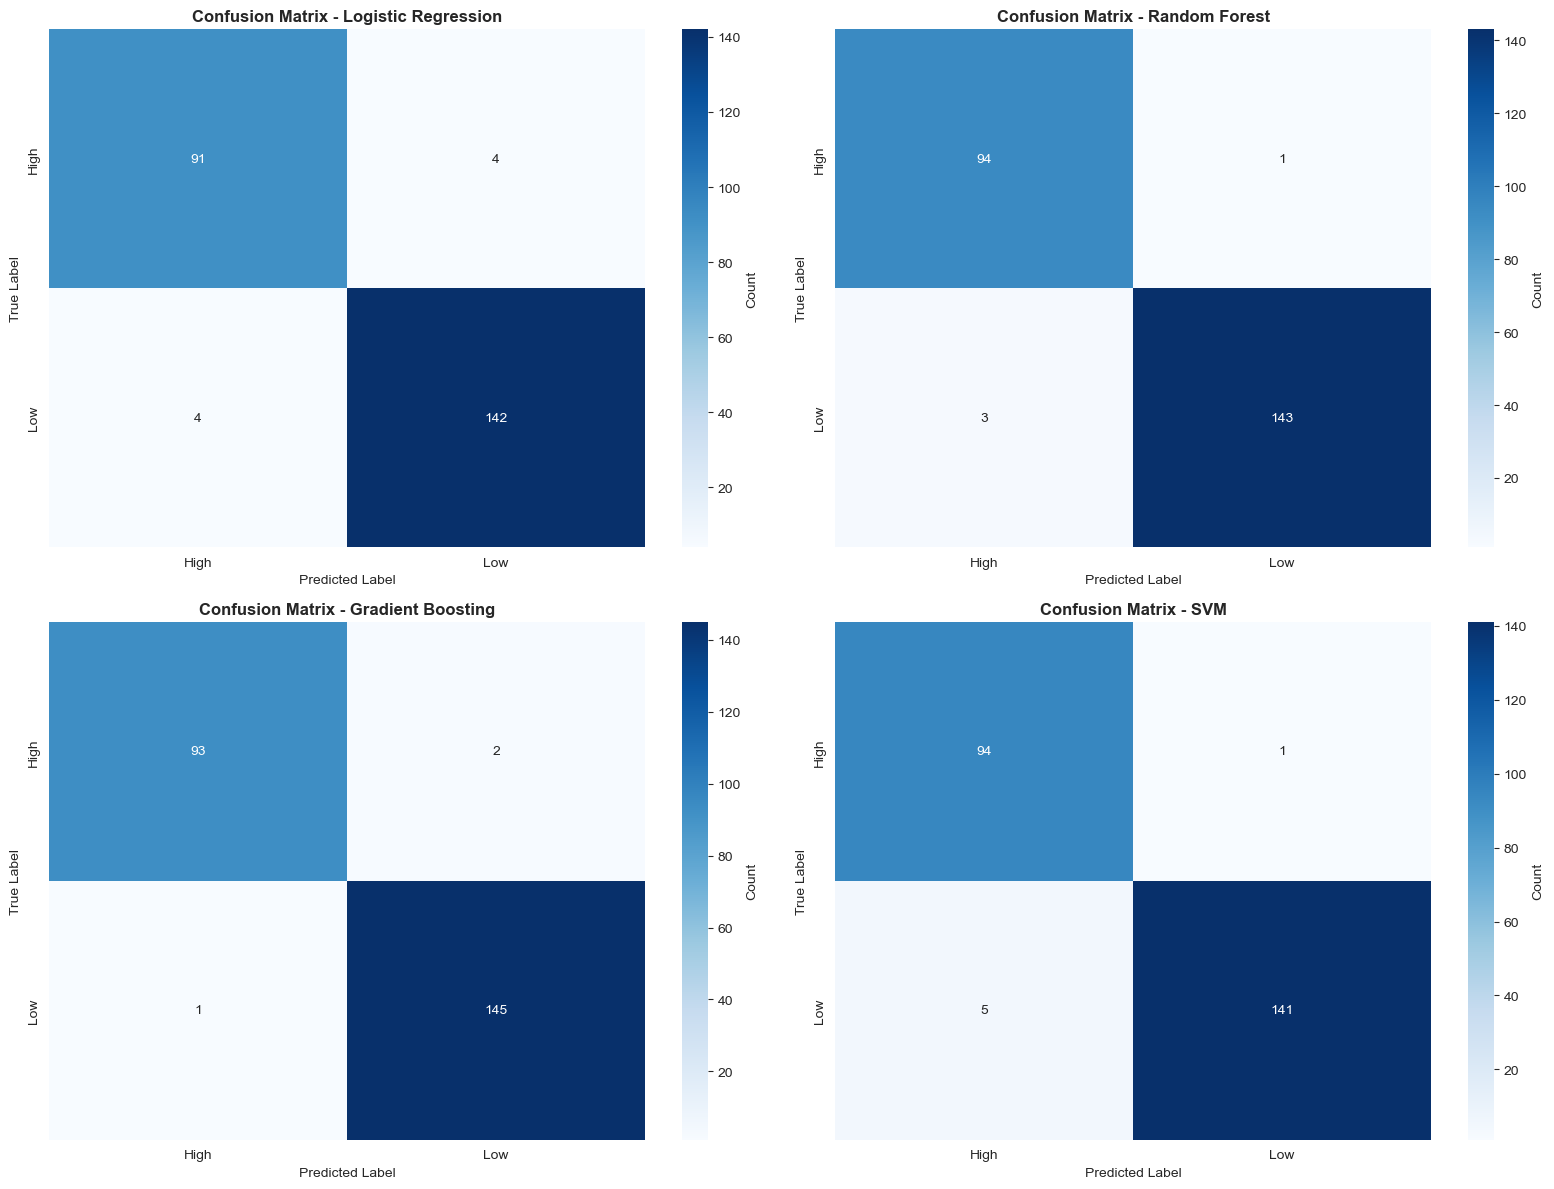

In [52]:
# ============================================================================
# CONFUSION MATRICES
# ============================================================================
print("\n" + "="*80)
print("CONFUSION MATRICES")
print("="*80)

print("\nGenerating confusion matrices...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, (model_name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_,
                cbar_kws={'label': 'Count'})
    axes[idx].set_title(f'Confusion Matrix - {model_name}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()


ROC CURVES

Generating ROC curves...


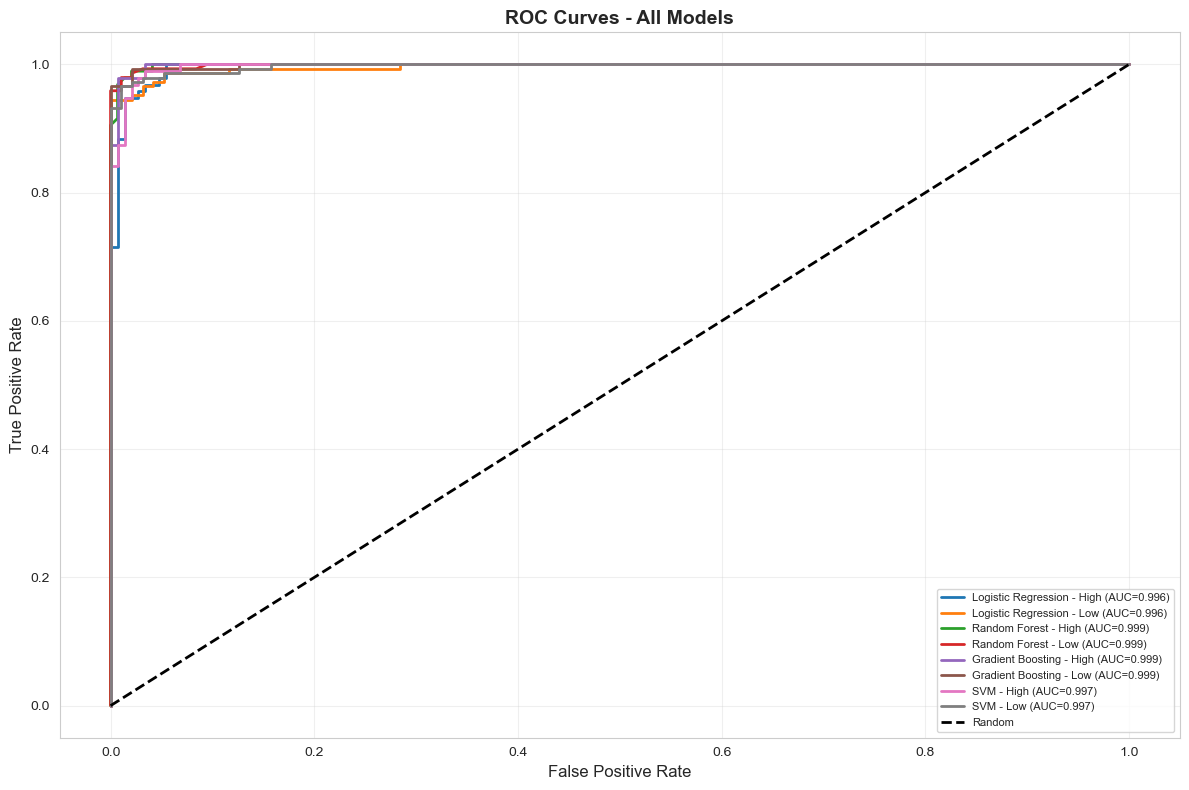

In [53]:
# ============================================================================
# ROC CURVES
# ============================================================================
print("\n" + "="*80)
print("ROC CURVES")
print("="*80)

print("\nGenerating ROC curves...")
plt.figure(figsize=(12, 8))

for model_name, result in results.items():
    y_test_bin = pd.get_dummies(y_test)
    
    for i, class_name in enumerate(label_encoder.classes_):
        fpr, tpr, _ = roc_curve(y_test_bin.iloc[:, i], result['probabilities'][:, i])
        auc_score = roc_auc_score(y_test_bin.iloc[:, i], result['probabilities'][:, i])
        plt.plot(fpr, tpr, label=f'{model_name} - {class_name} (AUC={auc_score:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - All Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=8)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


FEATURE IMPORTANCE

Generating feature importance plots...


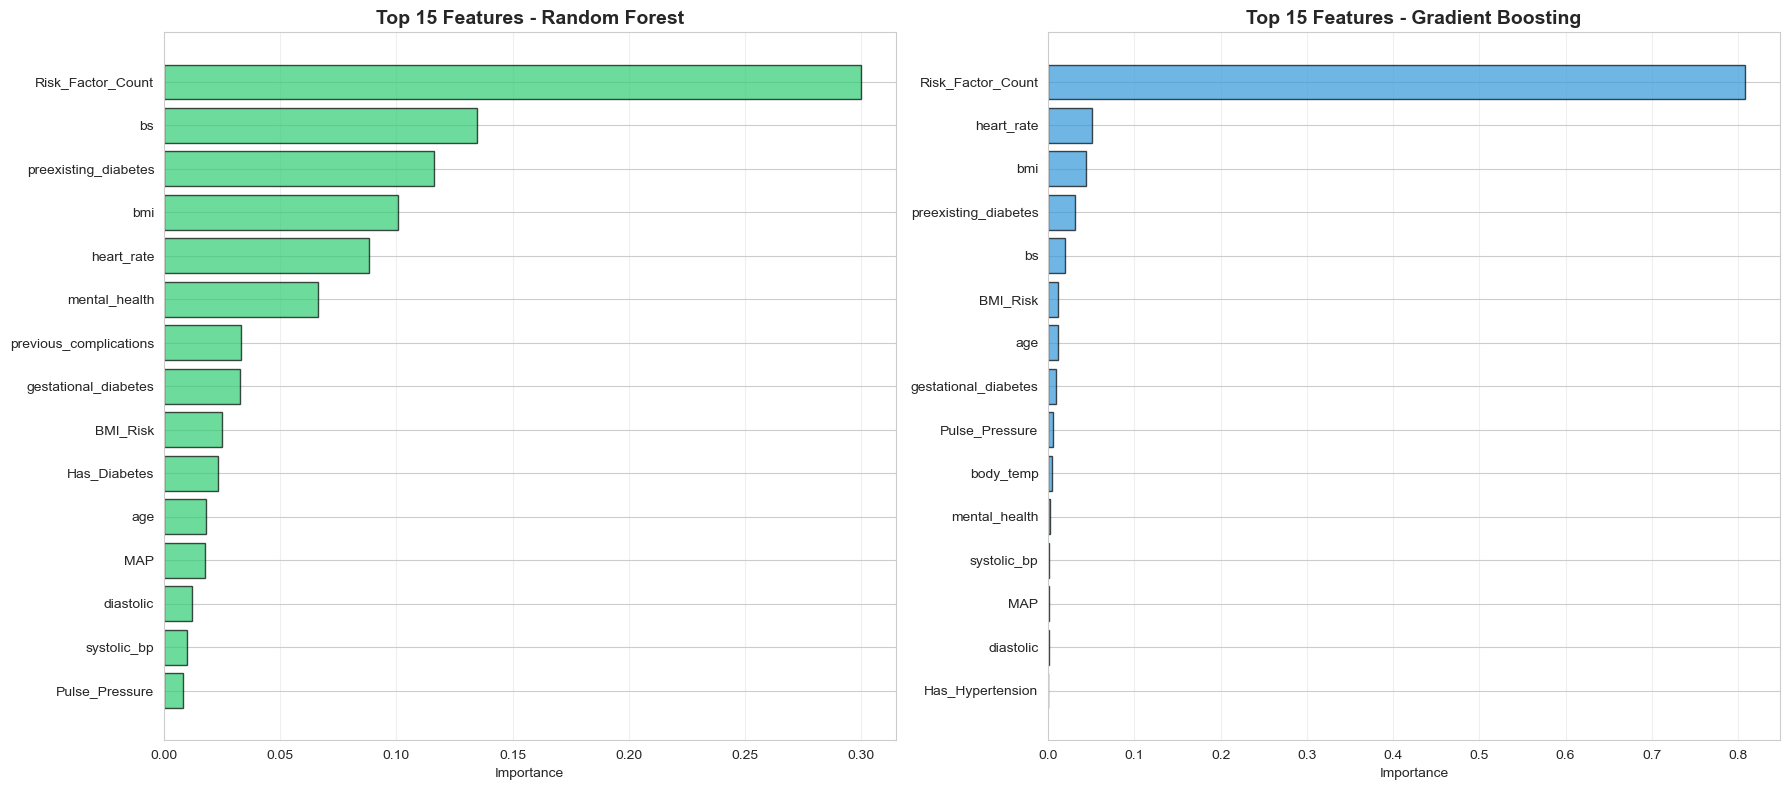

In [54]:
# ============================================================================
# FEATURE IMPORTANCE
# ============================================================================
print("\n" + "="*80)
print("FEATURE IMPORTANCE")
print("="*80)

print("\nGenerating feature importance plots...")
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Random Forest
rf_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=True).tail(15)

axes[0].barh(rf_importance['feature'], rf_importance['importance'], color='#2ecc71', alpha=0.7, edgecolor='black')
axes[0].set_title('Top 15 Features - Random Forest', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Importance')
axes[0].grid(axis='x', alpha=0.3)

# Gradient Boosting
gb_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=True).tail(15)

axes[1].barh(gb_importance['feature'], gb_importance['importance'], color='#3498db', alpha=0.7, edgecolor='black')
axes[1].set_title('Top 15 Features - Gradient Boosting', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Importance')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


CROSS-VALIDATION (5-Fold)

Logistic Regression:
  F1-Scores: [0.98450545 0.98443756 0.96377127 0.97927461 0.96358415]
  Mean: 0.9751 (+/- 0.0191)

Random Forest:
  F1-Scores: [0.97931986 0.98963731 0.96897979 0.98443756 0.95851214]
  Mean: 0.9762 (+/- 0.0223)

Gradient Boosting:
  F1-Scores: [0.97931986 0.98443756 0.98450545 0.98963731 0.97921393]
  Mean: 0.9834 (+/- 0.0078)

SVM:
  F1-Scores: [0.9793601  0.98963731 0.96909314 0.98443756 0.96888411]
  Mean: 0.9783 (+/- 0.0165)

Generating cross-validation plot...


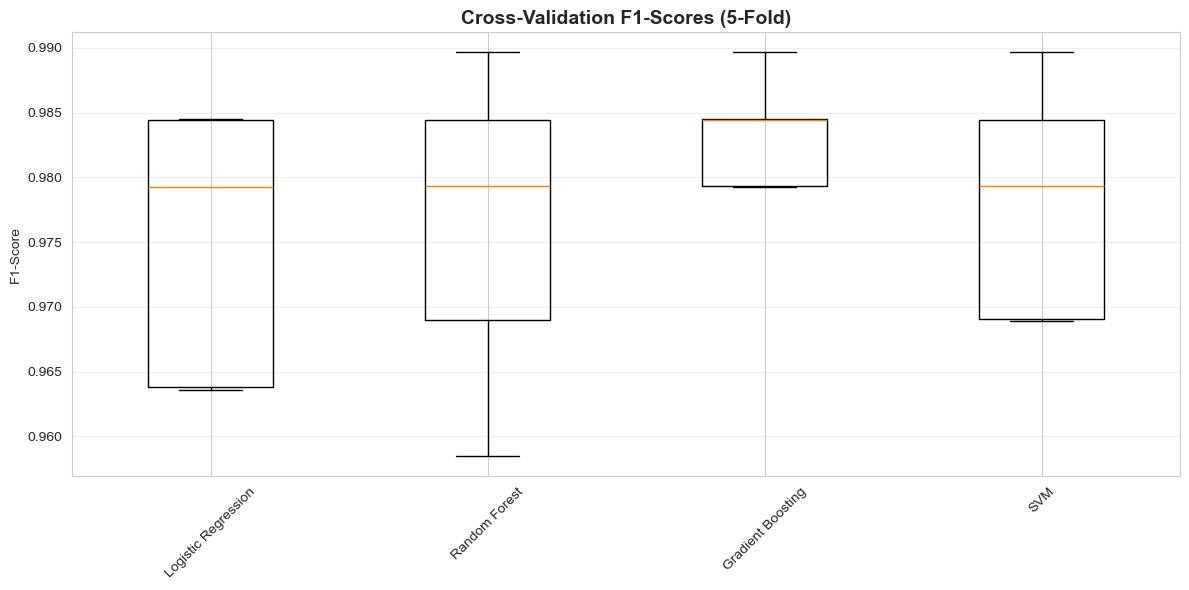

In [55]:
# ============================================================================
# CROSS-VALIDATION
# ============================================================================
print("\n" + "="*80)
print("CROSS-VALIDATION (5-Fold)")
print("="*80)

cv_results = {}

for model_name, model in models.items():
    print(f"\n{model_name}:")
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='f1_weighted')
    cv_results[model_name] = scores
    print(f"  F1-Scores: {scores}")
    print(f"  Mean: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

print("\nGenerating cross-validation plot...")
plt.figure(figsize=(12, 6))
plt.boxplot([cv_results[m] for m in cv_results.keys()], labels=cv_results.keys())
plt.title('Cross-Validation F1-Scores (5-Fold)', fontsize=14, fontweight='bold')
plt.ylabel('F1-Score')
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [56]:
# ============================================================================
# HYPERPARAMETER TUNING
# ============================================================================
print("\n" + "="*80)
print("HYPERPARAMETER TUNING")
print("="*80)

print(f"\nTuning {best_model_name}...")

if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    base_model = RandomForestClassifier(random_state=42, n_jobs=-1)
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10]
    }
    base_model = GradientBoostingClassifier(random_state=42)
elif best_model_name == 'SVM':
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01],
        'kernel': ['rbf', 'poly']
    }
    base_model = SVC(probability=True, random_state=42)
else:
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }
    base_model = LogisticRegression(random_state=42, max_iter=1000)

print(f"\nParameter grid: {param_grid}")
print("\nPerforming grid search...")

grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV F1-score: {grid_search.best_score_:.4f}")

best_tuned_model = grid_search.best_estimator_
y_pred_tuned = best_tuned_model.predict(X_test_scaled)

print("\nTuned model performance:")
print(classification_report(y_test, y_pred_tuned, target_names=label_encoder.classes_))

tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
tuned_f1 = f1_score(y_test, y_pred_tuned, average='weighted')

print(f"\nAccuracy: {tuned_accuracy:.4f}")
print(f"F1-Score: {tuned_f1:.4f}")


HYPERPARAMETER TUNING

Tuning Gradient Boosting...

Parameter grid: {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7], 'min_samples_split': [2, 5, 10]}

Performing grid search...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}
Best CV F1-score: 0.9865

Tuned model performance:
              precision    recall  f1-score   support

        High       0.98      0.98      0.98        95
         Low       0.99      0.99      0.99       146

    accuracy                           0.98       241
   macro avg       0.98      0.98      0.98       241
weighted avg       0.98      0.98      0.98       241


Accuracy: 0.9834
F1-Score: 0.9834


In [58]:
# ============================================================================
# SAVE MODELS
# ============================================================================
print("\n" + "="*80)
print("SAVING MODELS")
print("="*80)

model_filename = f'best_model_hachathon_{best_model_name.lower().replace(" ", "_")}.pkl'
joblib.dump(best_tuned_model, model_filename)
print(f"Saved: {model_filename}")

scaler_filename = 'scaler_hackathon.pkl'
joblib.dump(scaler, scaler_filename)
print(f"Saved: {scaler_filename}")

encoder_filename = 'label_encoder_hackathon.pkl'
joblib.dump(label_encoder, encoder_filename)
print(f"Saved: {encoder_filename}")

feature_filename = 'feature_names_hackathon.pkl'
joblib.dump(feature_columns, feature_filename)
print(f"Saved: {feature_filename}")

metadata = {
    'model_name': best_model_name,
    'model_type': type(best_tuned_model).__name__,
    'best_params': grid_search.best_params_,
    'test_accuracy': tuned_accuracy,
    'test_f1_score': tuned_f1,
    'feature_count': len(feature_columns),
    'training_samples': X_train.shape[0],
    'test_samples': X_test.shape[0],
    'classes': label_encoder.classes_.tolist(),
    'trained_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

metadata_filename = 'model_hackathon.pkl'
joblib.dump(metadata, metadata_filename)
print(f"Saved: {metadata_filename}")

processed_data_filename = 'processed_data_hackathon.csv'
df.to_csv(processed_data_filename, index=False)
print(f"Saved: {processed_data_filename}")


SAVING MODELS
Saved: best_model_hachathon_gradient_boosting.pkl
Saved: scaler_hackathon.pkl
Saved: label_encoder_hackathon.pkl
Saved: feature_names_hackathon.pkl
Saved: model_hackathon.pkl
Saved: processed_data_hackathon.csv


In [60]:
# ============================================================================
# PREDICTION EXAMPLE
# ============================================================================
print("\n" + "="*80)
print("PREDICTION EXAMPLE")
print("="*80)

example_patient = {
    'age': 28,
    'systolic_bp': 145,
    'diastolic': 95,
    'bs': 8.5,
    'body_temp': 98.6,
    'bmi': 32.5,
    'heart_rate': 105,
    'previous_complications': 1,
    'preexisting_diabetes': 0,
    'gestational_diabetes': 1,
    'mental_health': 0
}

print("\nExample patient data:")
for key, value in example_patient.items():
    print(f"  {key}: {value}")

example_df = pd.DataFrame([example_patient])
example_df['MAP'] = (example_df['systolic_bp'] + 2 * example_df['diastolic']) / 3
example_df['Pulse_Pressure'] = example_df['systolic_bp'] - example_df['diastolic']
example_df['Has_Hypertension'] = ((example_df['systolic_bp'] >= 140) | (example_df['diastolic'] >= 90)).astype(int)
example_df['Has_Diabetes'] = (example_df['bs'] >= 7.0).astype(int)
example_df['Has_Fever'] = (example_df['body_temp'] > 37.5).astype(int)
example_df['Has_Tachycardia'] = (example_df['heart_rate'] > 100).astype(int)
example_df['Risk_Factor_Count'] = (
    example_df['previous_complications'] + example_df['preexisting_diabetes'] + 
    example_df['gestational_diabetes'] + example_df['mental_health'] +
    example_df['Has_Hypertension'] + example_df['Has_Diabetes'] + example_df['Has_Tachycardia']
)
example_df['Age_Risk'] = ((example_df['age'] < 20) | (example_df['age'] > 35)).astype(int)
example_df['BMI_Risk'] = ((example_df['bmi'] < 18.5) | (example_df['bmi'] >= 30)).astype(int)

example_features = example_df[feature_columns]
example_scaled = scaler.transform(example_features)

prediction = best_tuned_model.predict(example_scaled)
prediction_proba = best_tuned_model.predict_proba(example_scaled)

predicted_risk = label_encoder.inverse_transform(prediction)[0]
risk_probabilities = dict(zip(label_encoder.classes_, prediction_proba[0]))

print("\nPrediction results:")
print(f"Predicted risk level: {predicted_risk}")
print("\nRisk probabilities:")
for risk_level, prob in risk_probabilities.items():
    print(f"  {risk_level}: {prob*100:.2f}%")

print("\nClinical interpretation:")
if predicted_risk == 'High':
    print("  HIGH RISK - Immediate medical attention recommended")
    print("  - Schedule urgent consultation")
    print("  - Monitor vitals daily")
    print("  - Consider hospitalization if symptoms worsen")
elif predicted_risk == 'Medium':
    print("  MEDIUM RISK - Close monitoring required")
    print("  - Follow-up within 1-2 weeks")
    print("  - Monitor vital signs regularly")
else:
    print("  LOW RISK - Continue routine prenatal care")
    print("  - Maintain regular check-ups")
    print("  - Continue healthy lifestyle")


PREDICTION EXAMPLE

Example patient data:
  age: 28
  systolic_bp: 145
  diastolic: 95
  bs: 8.5
  body_temp: 98.6
  bmi: 32.5
  heart_rate: 105
  previous_complications: 1
  preexisting_diabetes: 0
  gestational_diabetes: 1
  mental_health: 0

Prediction results:
Predicted risk level: High

Risk probabilities:
  High: 93.79%
  Low: 6.21%

Clinical interpretation:
  HIGH RISK - Immediate medical attention recommended
  - Schedule urgent consultation
  - Monitor vitals daily
  - Consider hospitalization if symptoms worsen


In [61]:
# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

print(f"\nCompleted: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"\nDataset: {df.shape[0]} samples, {len(feature_columns)} features")
print(f"Models trained: {len(models)}")
print(f"Best model: {best_model_name}")
print(f"Best F1-Score: {tuned_f1:.4f}")
print(f"\nModels saved to: ml-model/models/")
print(f"Processed data saved to: ml-model/data/processed/")

print("\n" + "="*80)


ANALYSIS COMPLETE

Completed: 2025-10-16 23:34:15

Dataset: 1205 samples, 20 features
Models trained: 4
Best model: Gradient Boosting
Best F1-Score: 0.9834

Models saved to: ml-model/models/
Processed data saved to: ml-model/data/processed/

